In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
    !pip3 install pickle5 -q
    !apt-get install p7zip-full -q
    !7z x 'drive/MyDrive/Colab Notebooks/Project/FreiHAND_split.7z'
    !7z x 'drive/MyDrive/Colab Notebooks/Project/RHD_published_v2.zip'
    !cp 'drive/MyDrive/Colab Notebooks/Project/Networks.py' .
    !cp 'drive/MyDrive/Colab Notebooks/Project/HandDataset.py' .
    !cp 'drive/MyDrive/Colab Notebooks/Project/Rotations.py' .
    PATH = "drive/MyDrive/Colab Notebooks/Project/"
except:
    IN_COLAB = False
    PATH = ""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading package lists...
Building dependency tree...
Reading state information...
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 482507128 bytes (461 MiB)

Extracting archive: drive/MyDrive/Colab Notebooks/Project/FreiHAND_pub_v2.7z
--
Path = drive/MyDrive/Colab Notebooks/Project/FreiHAND_pub_v2.7z
Type = 7z
Physical Size = 482507128
Headers Size = 409509
Method = LZMA2:24
Solid = +
Blocks = 1

  0%    
Would you like to replace the existing file:
  Path:     ./FreiHAND_pub_v2/FreiHAND_anno_training.pickle
  

In [ ]:
if IN_COLAB:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Not connected to a GPU')
    else:
        print(gpu_info)

Sat Nov 27 21:57:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from importlib import reload

from HandDataset import *
from Networks import *

manualSeed = 42
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [ ]:
batch_size = 128
img_size = 64
nc, nz = 3, 128 # number of channels in training images
nf_enc, nf_dec, ndf = 64, 64, 64
num_epochs = 30
lr, beta1 = 0.0002, 0.5 # hyperparam for Adam optimizers
num_workers = 16
lambda_mse = 1e-6

In [ ]:
real_transform = transforms.Compose([
    transforms.CenterCrop(112),
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((.5,.5,.5),(.5,.5,.5)) # (replace with actual mean and std)
])

real_ds = HandDataset(
    img_dir='FreiHAND_pub_v2/training/rgb',
    mask_dir='FreiHAND_pub_v2/training/mask',
    anno_path='FreiHAND_pub_v2/FreiHAND_anno_training.pickle', # incomplete (only contains xyz data)
    zfill=8,
    ext='.jpg',
    black_size=224,
    masked=True,
    transform=real_transform,
    normalise=False,
)

In [ ]:
real_loader = DataLoader(real_ds, batch_size=batch_size, shuffle=True, drop_last=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

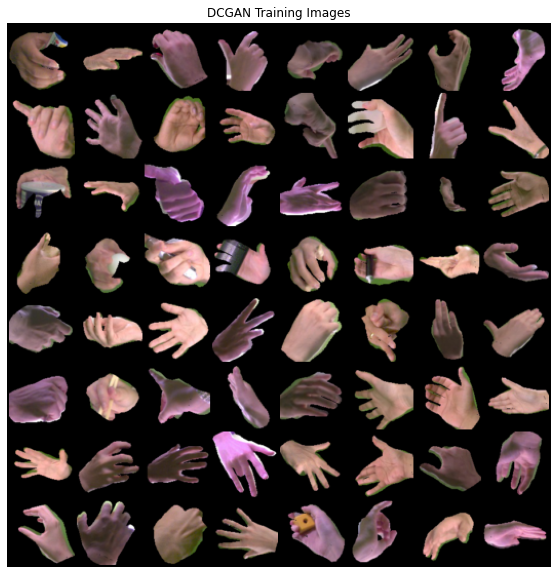

In [ ]:
# Plot some training images
real_batch = next(iter(real_loader))[0]

plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('DCGAN Training Images')
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64],
                                        padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
G = Decoder(nz=nz, nf=nf_enc).to(device)
G.apply(weights_init)

Decoder(
  (fc): Linear(in_features=128, out_features=16384, bias=False)
  (conv1): ConvTranspose2d(256, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
  (conv2): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
  (conv3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
  (conv4): Conv2d(64, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (bn1): BatchNorm1d(16384, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (activ): LeakyReLU(negative_slope=0.2)
)

In [ ]:
D = Discriminator(ndf=nf_dec).to(device)
D.apply(weights_init)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (bn_fc): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (FC1): Linear(in_features=8192, out_features=512, bias=False)
  (FC2): Linear(in_features=512, out_features=66, bias=True)
  (activ): LeakyReLU(negative_slope=0.2)
)

In [ ]:
loss_fn = nn.BCELoss()
fixed_noise = torch.randn(64, nz).to(device) # fixed standard normal noise

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []

iters = 0
epoch = 0

In [ ]:
print("Starting Training Loop...")
while epoch < num_epochs:
    for i, real_batch in enumerate(real_loader):
        ## Update D network
        D.zero_grad()
        real_imgs = real_batch[0].to(device)
        Zp = torch.randn( batch_size, nz ).to(device)
        Xp = G(Zp)
        
        disc_class_real,_,_ = D(real_imgs)
        D_x = disc_class_real.mean().item()
        errD_real = loss_fn(disc_class_real, torch.ones( batch_size ).to(device))
        
        disc_class_sampled,_,_ = D(Xp.detach())
        D_G_z1 = disc_class_sampled.mean().item()
        errD_fake = loss_fn(disc_class_sampled, torch.zeros( batch_size ).to(device))
        
        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()
        
        ## Update G network
        G.zero_grad()
        
        disc_class_sampled,_,_ = D(Xp)
        D_G_z2 = disc_class_sampled.mean().item()
        errG = loss_fn(disc_class_sampled, torch.ones( batch_size ).to(device))
        errG.backward()
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.3f\tLoss_G: %.3f\tD(x): %.3f\tD(G(z)): %.3f / %.3f'
                  % (epoch, num_epochs, i, len(real_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if iters % 500 == 0:
            with torch.no_grad():
                fake = G(fixed_noise).detach().cpu()
            
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            plt.figure(figsize=(8,8))
            plt.axis('off')
            plt.title('Fixed noise generated')
            plt.imshow(np.transpose(vutils.make_grid(fake[:64],
                                                    padding=2, normalize=True).cpu(),(1,2,0)))
            plt.pause(0.01)
        
        iters += 1
    epoch += 1
        

Output hidden; open in https://colab.research.google.com to view.

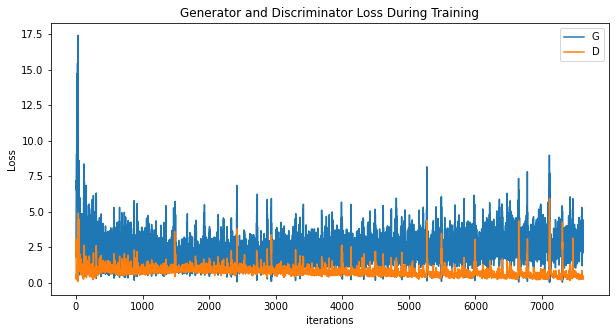

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
torch.save(D.state_dict(), PATH+'models/gan/D_27_11_21_epoch_{}.pth'.format(epoch))
torch.save(G.state_dict(), PATH+'models/gan/G_27_11_21_epoch_{}.pth'.format(epoch))